In [163]:
import pandas as pd

df_tmp = pd.read_csv("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/benchmarks/counter_factuals_sensitivity/tmp/_build/scalar_database.csv")
df_co2 = pd.read_csv("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/benchmarks/counter_factuals_sensitivity/CO2/_build/scalar_database.csv")
df_pre = pd.read_csv("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/benchmarks/counter_factuals_sensitivity/pre_spfh/_build/scalar_database.csv")
df = pd.read_csv('Means_Combined.csv')

df_tmp['Experiment'] = "tmp"
df_co2['Experiment'] = "co2"
df_pre['Experiment'] = "pre"

df = pd.concat([df_tmp, df_co2, df_pre], ignore_index=True)
df

,Section,Variable,Source,Model,ScalarName,AnalysisType,Region,ScalarType,Units,Data,Weight,Experiment
0,CarbonStocks,CarboninVegetation,ENSMEAN,tmp_0,Benchmark Period Mean (intersection),MeanState,global,scalar,g m-2,2557.770000,1.0,tmp
1,CarbonStocks,CarboninVegetation,ENSMEAN,tmp_0,Benchmark Period Mean (complement),MeanState,global,scalar,g m-2,0.451347,1.0,tmp
2,CarbonStocks,CarboninVegetation,ENSMEAN,tmp_0,Period Mean (original grids),MeanState,global,scalar,g m-2,2741.900000,1.0,tmp
3,CarbonStocks,CarboninVegetation,ENSMEAN,tmp_0,Model Period Mean (intersection),MeanState,global,scalar,g m-2,2741.900000,1.0,tmp
4,CarbonStocks,CarboninVegetation,ENSMEAN,tmp_0,Model Period Mean (complement),MeanState,global,scalar,g m-2,NaN,1.0,tmp
...,...,...,...,...,...,...,...,...,...,...,...,...
22745,WaterCycle,Evapotranspiration,ENSMEAN,pre_spfh_minus_100pct,Overall Score,MeanState,global,score,1,0.669330,1.0,pre
22746,WaterCycle,Evapotranspiration,ENSMEAN,pre_spfh_minus_100pct,Overall Score,MeanState,tropics,score,1,0.595333,1.0,pre
22747,WaterCycle,Evapotranspiration,ENSMEAN,pre_spfh_minus_100pct,Overall Score,MeanState,subtropics,score,1,0.600301,1.0,pre
22748,WaterCycle,Evapotranspiration,ENSMEAN,pre_spfh_minus_100pct,Overall Score,MeanState,temperate,score,1,0.661189,1.0,pre


# General Formatting

In [164]:
df.drop(columns=['Section','Source','AnalysisType', 'ScalarType', 'Weight'], inplace=True)

df = df.rename(columns={'ScalarName': 'Type'})

df = df[df['Type'].isin(['Benchmark Period Mean (intersection)', 'Model Period Mean (intersection)'])]

In [165]:


df.loc[df['Type'] == 'Benchmark Period Mean (intersection)', 'Type'] = 'Benchmark'
df.loc[df['Type'] == 'Model Period Mean (intersection)', 'Type'] = 'Model'


# --- Drop duplicate Benchmark rows per (Variable, Region) --- #
mask_bench = df['Type'] == 'Benchmark'

# Mark duplicates only among Benchmark rows
dupes_bench = df[mask_bench].duplicated(subset=['Variable', 'Region'], keep='first')

# Drop those duplicates, keep everything else
df = df[~(mask_bench & dupes_bench)]

# Optional: sort for nicer viewing
df = df.sort_values(['Variable', 'Region', 'Type'])



### Experiment specific formatting

In [166]:
# Add it to the tmp global mean
import json

STD_JSON_PATH = "/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/src/dataset/std_dict.json"

with open(STD_JSON_PATH, "r") as f:
    std_dict = json.load(f)

In [167]:
# --- 1. CO₂ experiment ---
co2_mask = df['Experiment'] == 'co2'

# Extract signed percentage before "pct"
co2_str = df.loc[co2_mask, 'Model'].astype(str)
pct = co2_str.str.extract(r'([-+]?\d+)(?=pct$)', expand=False)

# Only keep rows where we actually matched something
valid_co2 = pct.notna()
pct_int = pct[valid_co2].astype(int)

# Convert to absolute CO₂ concentration for those rows
df.loc[co2_mask & valid_co2, 'Model'] = 300 * (1 + pct_int / 100.0)


# --- PRE (humidity/precipitation) experiment ---
pre_mask = df['Experiment'] == 'pre'

pre_str = df.loc[pre_mask, 'Model'].astype(str)

# Extract signed or unsigned integer before "pct"
pct_pre = pre_str.str.extract(r'([-+]?\d+)(?=pct$)', expand=False)

# Keep only parsed rows
valid_pre = pct_pre.notna()
vals = pct_pre[valid_pre].astype(int)

# NEW RULE: add a minus sign to all **non-zero** values
vals = vals.apply(lambda x: -abs(x) if x != 0 else 0)

df.loc[pre_mask & valid_pre, 'Model'] = vals
# Convert to integer (retains sign)
df.loc[pre_mask & valid_pre, 'Model'] = pct_pre[valid_pre].astype(int)

# --- 3. TMP (temperature) experiment ---
tmp_mask = df['Experiment'] == 'tmp'

tmp_str = df.loc[tmp_mask, 'Model'].astype(str)

# Extract signed integer after 'tmp_'
# e.g. tmp_-3 → -3, tmp_4 → 4
tmp_vals = tmp_str.str.extract(r'tmp_([-+]?\d+)$', expand=False)

valid_tmp = tmp_vals.notna()

if 'tmp' in std_dict:
    tmp_stats = std_dict['tmp']
    tmp_mean_K = float(tmp_stats['mean'])
    # Convert global mean from Kelvin to Celsius
    tmp_mean_C = tmp_mean_K - 273.15

    # Offsets (e.g. -3, +4) as float
    offsets = tmp_vals[valid_tmp].astype(float)

    # Absolute global mean temperature = mean + offset
    abs_tmp = tmp_mean_C + offsets

    # Store back in df['Model'] for tmp experiment
    df.loc[tmp_mask & valid_tmp, 'Model'] = abs_tmp.values
else:
    # Fallback: keep using plain offsets if no stats available
    df.loc[tmp_mask & valid_tmp, 'Model'] = tmp_vals[valid_tmp].astype(int)
    print("Warning: 'tmp' not found in std_dict; using offsets only.")

# --- 4. Benchmark: force Model to 0 where Type == 'benchmark' ---
bench_mask = df['Type'] == 'Benchmark'
df.loc[bench_mask, 'Model'] = 0

In [168]:
import matplotlib.pyplot as plt

# Your metadata dict
output_attributes = {
    "nbp":  "Net Biome Productivity",
    "gpp":  "Gross Primary Production",
    "npp":  "Net Primary Production",
    "ra":   "Autotrophic Respiration",
    "rh":   "Heterotrophic Respiration",
    "fLuc": "Land-Use Change Emissions",
    "fFire":"Fire Emissions",

    "mrro": "Total Runoff",
    "evapotrans": "Evapotranspiration",

    "cLitter": "Carbon in Litter Pool",
    "cSoil":   "Carbon in Soil Pool",
    "cVeg":    "Carbon in Vegetation",
    "cTotal":  "Total Carbon in Ecosystem",
    "cTotal_monthly": "Total Carbon in Ecosystem",

    "mrso": "Total Soil Moisture Content",

    "lai": "Leaf Area Index",
    "lai_avh15c1": "Leaf Area Index",
    "lai_modis":   "Leaf Area Index",
}

# Map ILAMB variable labels to the keys in output_attributes
VARIABLE_TO_KEY = {
    "NetBiomeProductivity": "nbp",
    "GrossPrimaryProduction": "gpp",
    "NetPrimaryProduction": "npp",
    "AutotrophicRespiration": "ra",
    "HeterotrophicRespiration": "rh",
    "LandUseChangeEmissions": "fLuc",
    "FireEmissions": "fFire",
    "TotalRunoff": "mrro",
    "Evapotranspiration": "evapotrans",
    "CarboninLitterPool": "cLitter",
    "CarboninSoilPool": "cSoil",
    "CarboninVegetation": "cVeg",
    "TotalCarboninEcosystem": "cTotal",
    "SoilMoisture": "mrso",
    "LeafAreaIndex": "lai",
}

In [169]:
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from cycler import cycler

# Minimal metadata: key -> long name
output_attributes = {
    "nbp":  "Net Biome Productivity",
    "gpp":  "Gross Primary Production",
    "npp":  "Net Primary Production",
    "ra":   "Autotrophic Respiration",
    "rh":   "Heterotrophic Respiration",
    "fLuc": "Land-Use Change Emissions",
    "fFire":"Fire Emissions",

    "mrro": "Total Runoff",
    "evapotrans": "Evapotranspiration",

    "cLitter": "Carbon in Litter Pool",
    "cSoil":   "Carbon in Soil Pool",
    "cVeg":    "Carbon in Vegetation",
    "cTotal":  "Total Carbon in Ecosystem",
    "cTotal_monthly": "Total Carbon in Ecosystem",

    "mrso": "Total Soil Moisture Content",

    "lai": "Leaf Area Index",
    "lai_avh15c1": "Leaf Area Index",
    "lai_modis":   "Leaf Area Index",
}

# Map ILAMB variable labels to the keys in output_attributes
VARIABLE_TO_KEY = {
    "NetBiomeProductivity": "nbp",
    "GrossPrimaryProduction": "gpp",
    "NetPrimaryProduction": "npp",
    "AutotrophicRespiration": "ra",
    "HeterotrophicRespiration": "rh",
    "LandUseChangeEmissions": "fLuc",
    "FireEmissions": "fFire",
    "TotalRunoff": "mrro",
    "Evapotranspiration": "evapotrans",
    "CarboninLitterPool": "cLitter",
    "CarboninSoilPool": "cSoil",
    "CarboninVegetation": "cVeg",
    "TotalCarboninEcosystem": "cTotal",
    "SoilMoisture": "mrso",
    "LeafAreaIndex": "lai",
}

STD_JSON_PATH = (
    "/Net/Groups/BGI/people/ecathain/"
    "TRENDY_Emulator_Scripts/NewModel/src/dataset/std_dict.json"
)

In [170]:
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from cycler import cycler

def plot_variable_response(
    df,
    variable,
    forcing_var="co2",
    std_json_path=STD_JSON_PATH,
    xlim=None,
    ylim=None,
    xlabel=None,
    ylabel=None,
    mean_line=False,
    sd_line=False,
    min_line=False,
    max_line=False,
    trendy_cross_legend=False,
):
    """
    Plot Data vs Model for a given response variable under a specified forcing.

    - Lines with circle markers for each Region where Type != 'Benchmark'
    - 'x' markers for Benchmark points in the same region colour
      (x-position taken from df['Model'])
    - Y label from output_attributes long_name + Units column (overridden by
      `ylabel` if provided)
    - X label inferred from forcing_var (overridden by `xlabel` if provided)
    - Optional vertical lines from std_dict.json:
        * mean_line=True   -> black dashed line at mean
        * sd_line=True     -> red dotted lines at mean ± 1 std
        * min_line=True    -> red dotted line at min
        * max_line=True    -> red dotted line at max
      For 'tmp', mean/std/min/max are stored in Kelvin and converted to Celsius.
      If drawn, these lines are also added to the legend.
    - Optional TRENDY ensemble mean cross legend entry controlled by
      `trendy_cross_legend`.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns:
            ['Variable', 'Region', 'Type', 'Model', 'Data', 'Units', 'Experiment'].
    variable : str
        ILAMB variable label to plot (e.g. 'GrossPrimaryProduction',
        'NetBiomeProductivity') or a key that can be mapped via VARIABLE_TO_KEY.
    forcing_var : str, default 'co2'
        Name of the forcing variable ('co2', 'tmp', or 'pre'):
          - used to filter df['Experiment']
          - used as key in std_dict.json
          - determines default x-axis label and unit handling
    std_json_path : str
        Path to the std_dict.json file.
    xlim : tuple or None
        Optional (xmin, xmax) for the x-axis.
    ylim : tuple or None
        Optional (ymin, ymax) for the y-axis.
    xlabel : str or None
        Optional explicit x-axis label (overrides automatic).
    ylabel : str or None
        Optional explicit y-axis label (overrides automatic).
    mean_line, sd_line, min_line, max_line : bool
        If True, draw vertical lines (and add legend entries) at mean, mean±std,
        min, max, respectively, using statistics from std_dict.json.
    trendy_cross_legend : bool
        If True, include a global legend entry showing a black 'x' labelled
        'TRENDY Mean (S0)'.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes
    """

    # --------- Resolve variable label used in df ---------
    var_values = df['Variable'].unique()
    if variable in var_values:
        var_label = variable
    else:
        # Try mapping from a short key like "gpp"
        var_key = variable.lower()
        inv_map = {v.lower(): k for k, v in VARIABLE_TO_KEY.items()}
        if var_key in inv_map:
            var_label = inv_map[var_key]
        else:
            raise ValueError(
                f"Could not match variable '{variable}' to any df['Variable'] value "
                f"or VARIABLE_TO_KEY entry."
            )

    sub = df[df['Variable'] == var_label].copy()
    if sub.empty:
        raise ValueError(f"No rows found for Variable == '{var_label}'")

    # --------- Restrict to the chosen experiment (co2/tmp/pre) ---------
    forcing_key = forcing_var.lower()
    sub = sub[sub['Experiment'].str.lower() == forcing_key]
    if sub.empty:
        raise ValueError(
            f"No rows left after filtering for Experiment == '{forcing_var}'. "
            f"Check df['Experiment'] values."
        )

    # --------- Units and long_name ---------
    units_vals = sub['Units'].dropna().unique()
    units = units_vals[0] if len(units_vals) > 0 else ""

    key = VARIABLE_TO_KEY.get(var_label, None)
    if key is None:
        long_name = var_label
    else:
        long_name = output_attributes.get(key, var_label)

    # --------- Figure + aesthetics ---------
    fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=300)

    # Muted, colour-blind-friendly palette
    palette = [
        "#4c72b0",  # blue
        "#55a868",  # green
        "#c44e52",  # red
        "#8172b3",  # purple
        "#ccb974",  # ochre
        "#64b5cd",  # light blue
        "#8c8c8c",  # grey
    ]
    ax.set_prop_cycle(cycler(color=palette))

    # Split model and benchmark rows
    model_rows = sub[sub['Type'] != 'Benchmark']
    bench_rows = sub[sub['Type'] == 'Benchmark']

    # --------- Plot regional lines + benchmarks ---------
    regions = sorted(model_rows['Region'].dropna().unique())
    for region in regions:
        r_data = model_rows[model_rows['Region'] == region]
        if r_data.empty:
            continue

        r_data = r_data.sort_values('Model')

        # Line with hollow circle markers
        line, = ax.plot(
            r_data['Model'],
            r_data['Data'],
            marker='o',
            markersize=4.5,
            markerfacecolor='none',
            linewidth=1.8,
            linestyle='-',
            label=region.title(),  # capitalise in legend
        )
        color = line.get_color()

        # Benchmarks for this region: x from df['Model'] (no hard-coded value)
        r_bench = bench_rows[bench_rows['Region'] == region]
        if not r_bench.empty:
            ax.plot(
                r_bench['Model'],
                r_bench['Data'],
                marker='x',
                linestyle='None',
                markersize=7,
                markeredgewidth=1.5,
                color=color,
            )

    # --------- Vertical lines from std_dict.json (optional) ---------
    # We'll collect legend handles for these here.
    line_handles = []

    try:
        with open(std_json_path, "r") as f:
            std_dict = json.load(f)
    except FileNotFoundError:
        print(f"Warning: std_dict.json not found at {std_json_path}; "
              "skipping mean/std/min/max lines.")
        std_dict = {}

    if forcing_key in std_dict and any([mean_line, sd_line, min_line, max_line]):
        stats = std_dict[forcing_key]

        mean = stats.get("mean", None)
        std = stats.get("std", None)
        min_val = stats.get("min", None)
        max_val = stats.get("max", None)

        # Convert temperature stats from K -> °C
        def _convert(x):
            if x is None:
                return None
            return x - 273.15 if forcing_key == "tmp" else x

        mean = _convert(mean)
        std = _convert(std) if std is not None else None
        min_val = _convert(min_val)
        max_val = _convert(max_val)

        # Helper to draw a single line
        def _vline(x_val, color="red", linestyle=":"):
            if x_val is not None:
                ax.axvline(
                    x_val,
                    color=color,
                    linestyle=linestyle,
                    linewidth=1.2,
                )

        # Mean
        if mean_line and mean is not None:
            _vline(mean, color="black", linestyle="--")
            line_handles.append(
                Line2D(
                    [], [], color="black", linestyle="--", linewidth=1.2,
                    label="Mean training data"
                )
            )

        # ±1σ
        if sd_line and (mean is not None) and (std is not None):
            _vline(mean - std, color="gray", linestyle="--")
            _vline(mean + std, color="gray", linestyle="--")
            line_handles.append(
                Line2D(
                    [], [], color="gray", linestyle="--", linewidth=1.2,
                    label="Mean ±1σ"
                )
            )

        # Min
        if min_line and min_val is not None:
            _vline(min_val)
            line_handles.append(
                Line2D(
                    [], [], color="red", linestyle="--", linewidth=1.2,
                    label="Min training data"
                )
            )

        # Max
        if max_line and max_val is not None:
            _vline(max_val)
            line_handles.append(
                Line2D(
                    [], [], color="red", linestyle="--", linewidth=1.2,
                    label="Max training data"
                )
            )

    elif forcing_key not in std_dict and any([mean_line, sd_line, min_line, max_line]):
        print(f"Warning: '{forcing_key}' not found in std_dict.json; "
              "no mean/std/min/max lines drawn.")

    # --------- Axes labels & limits ---------
    # X-axis label depending on forcing type
    if xlabel is not None:
        x_label = xlabel
    else:
        if forcing_key == "co2":
            x_label = r"CO$_2$ concentration (ppm)"
        elif forcing_key == "pre":
            x_label = "Precipitation percentage offset"
        elif forcing_key == "tmp":
            x_label = "Global mean temperature (°C)"
        else:
            x_label = forcing_var

    ax.set_xlabel(x_label, fontsize=11)

    if ylabel is not None:
        y_label = ylabel
    else:
        if units:
            y_label = f"{long_name} [{units}]"
        else:
            y_label = long_name

    ax.set_ylabel(y_label, fontsize=11)

    # Apply optional x/ylim
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.grid(True, alpha=0.3, linewidth=0.6)
    ax.tick_params(labelsize=9)

    # --------- Legend (outside, with optional TRENDY + line entries) ---------
    handles, labels = ax.get_legend_handles_labels()

    # Add vertical-line legend entries (avoid duplicates)
    for lh in line_handles:
        lbl = lh.get_label()
        if lbl and lbl not in labels:
            handles.append(lh)
            labels.append(lbl)

    if trendy_cross_legend:
        benchmark_handle = Line2D(
            [], [], color='black', marker='x', linestyle='None',
            markersize=7, markeredgewidth=1.5, label='TRENDY Mean (S0)'
        )
        if 'TRENDY Mean (S0)' not in labels:
            handles.append(benchmark_handle)
            labels.append('TRENDY Mean (S0)')

    ax.legend(
        handles=handles,
        labels=labels,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        frameon=False,
        title="Legend",
        title_fontsize=10,
        fontsize=9,
    )

    fig.tight_layout()
    return fig, ax

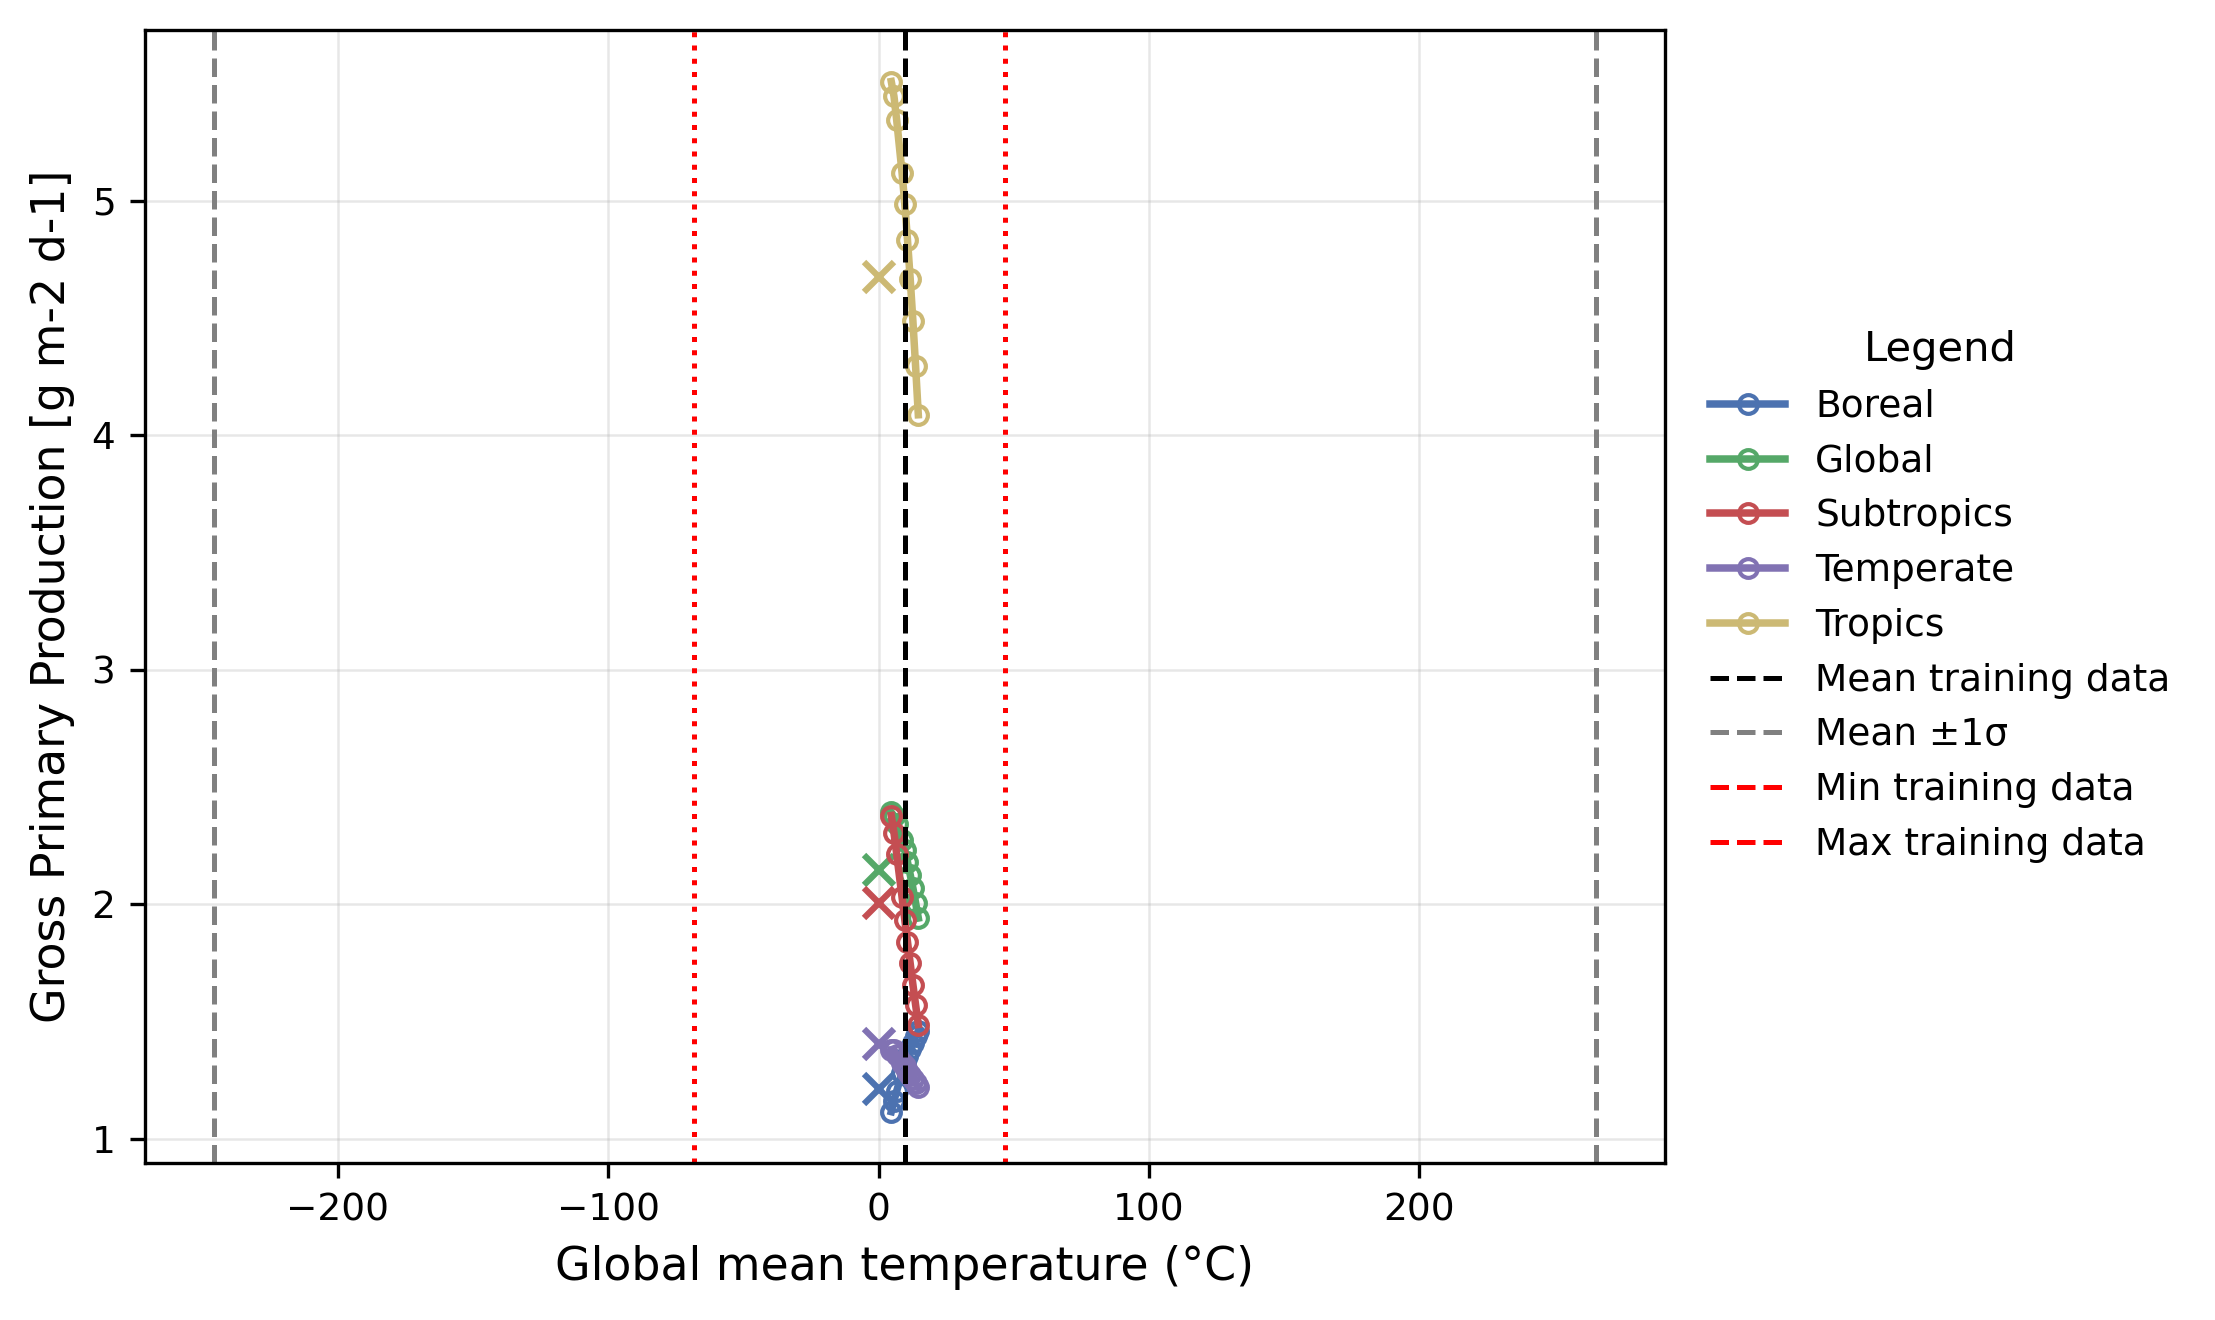

In [171]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response(df, variable="GrossPrimaryProduction",
                                 forcing_var="tmp", mean_line=True, sd_line=True, min_line=True, max_line=True)

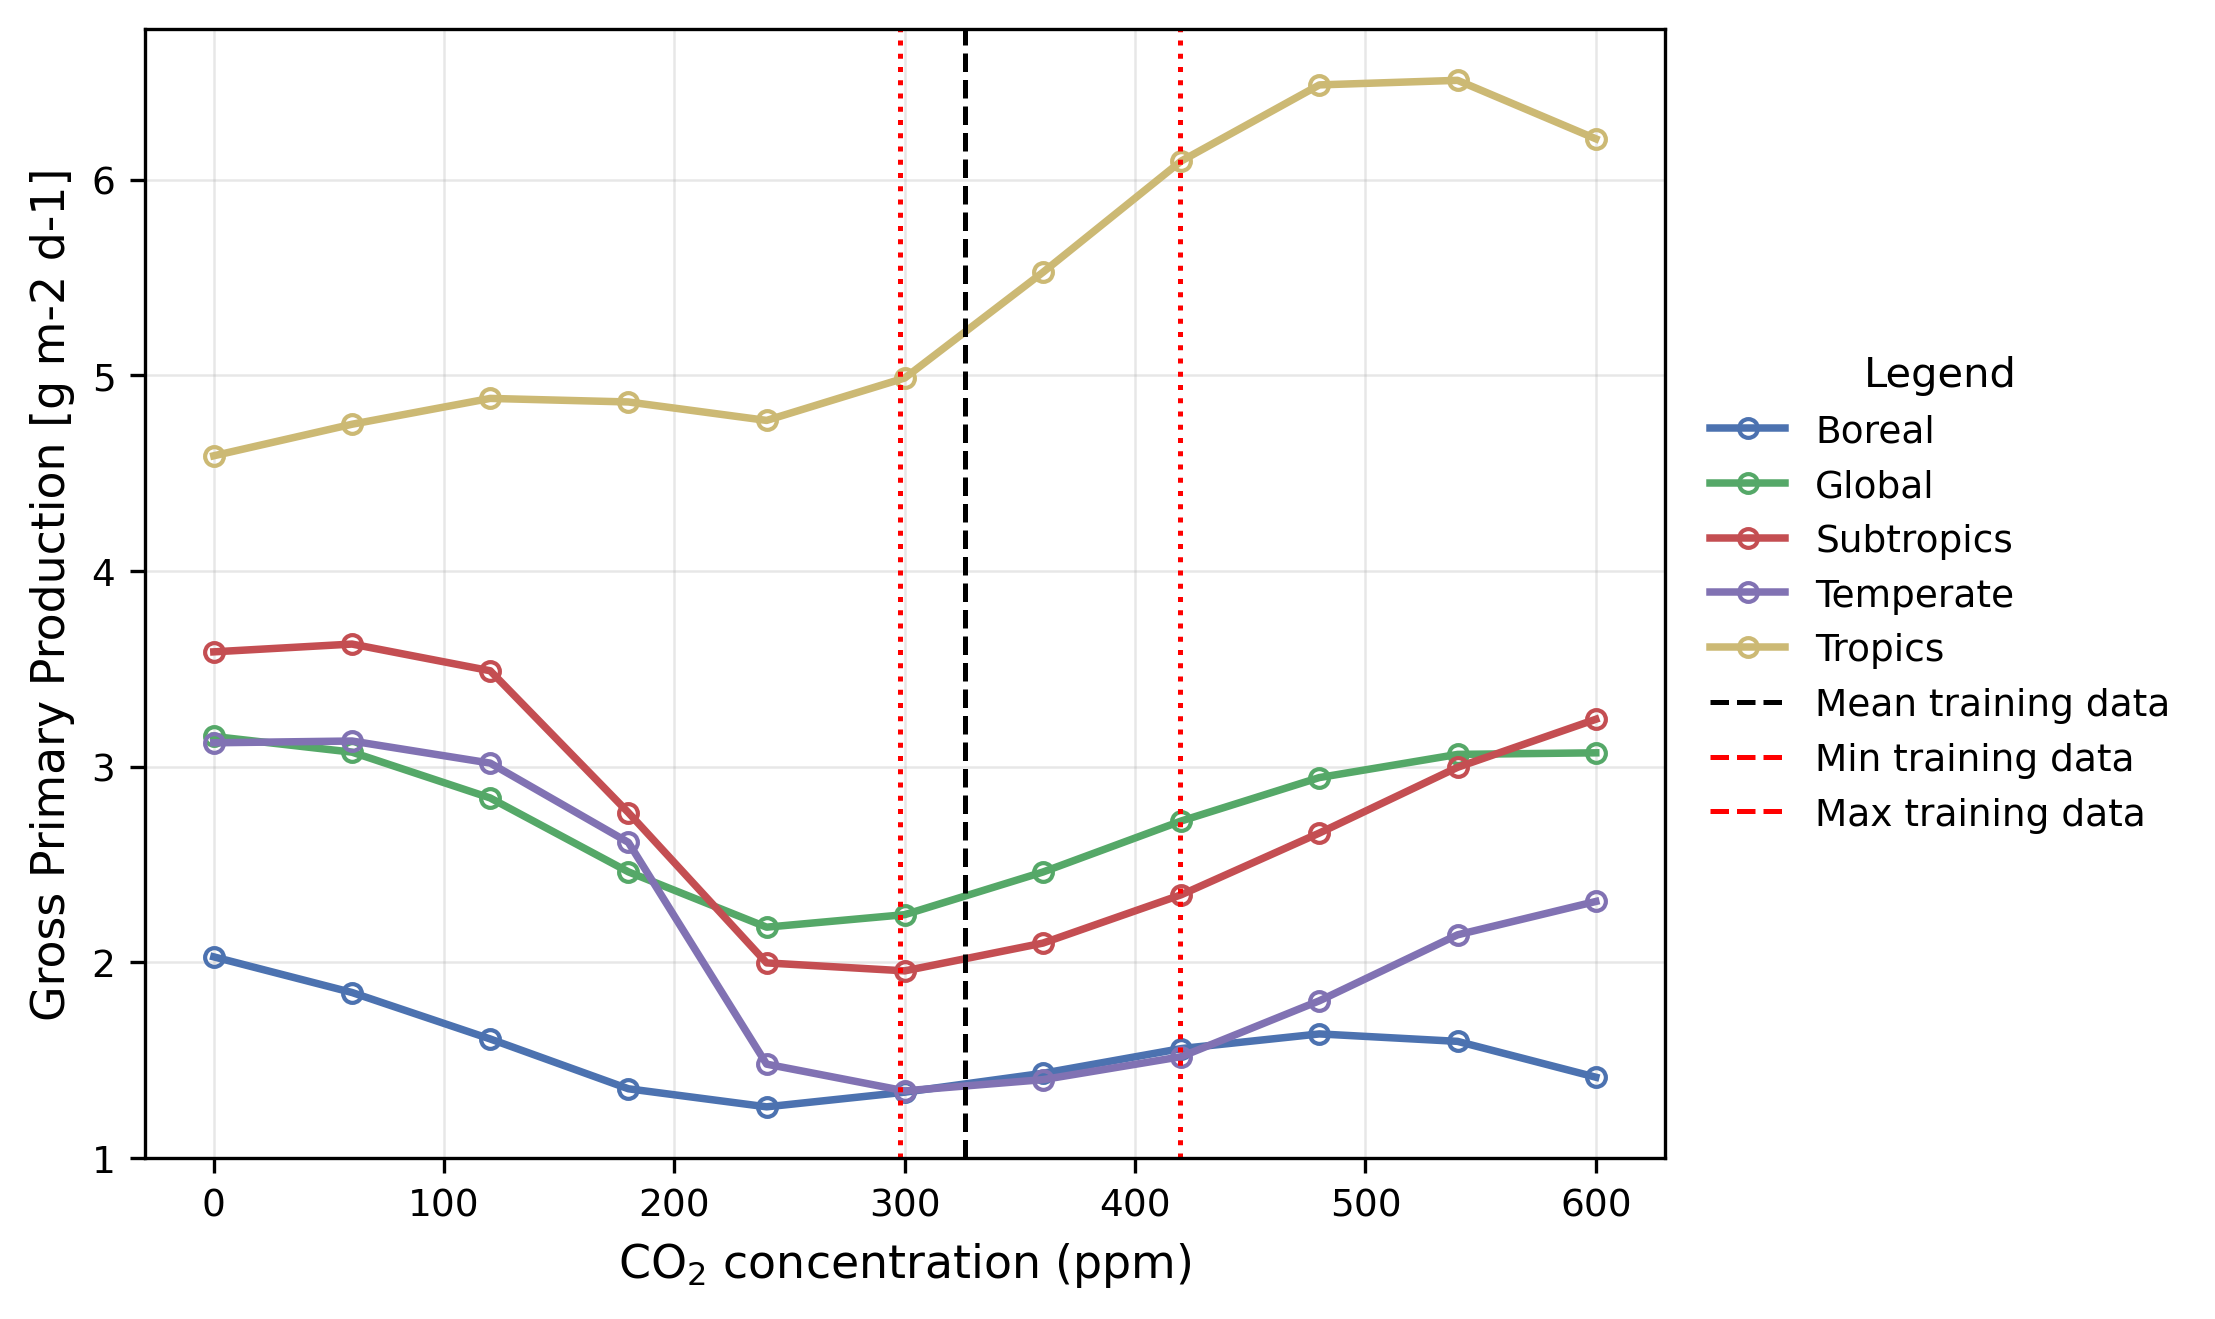

In [172]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response(df, variable="GrossPrimaryProduction",
                                 forcing_var="co2", mean_line=True, sd_line=False, min_line=True, max_line=True)

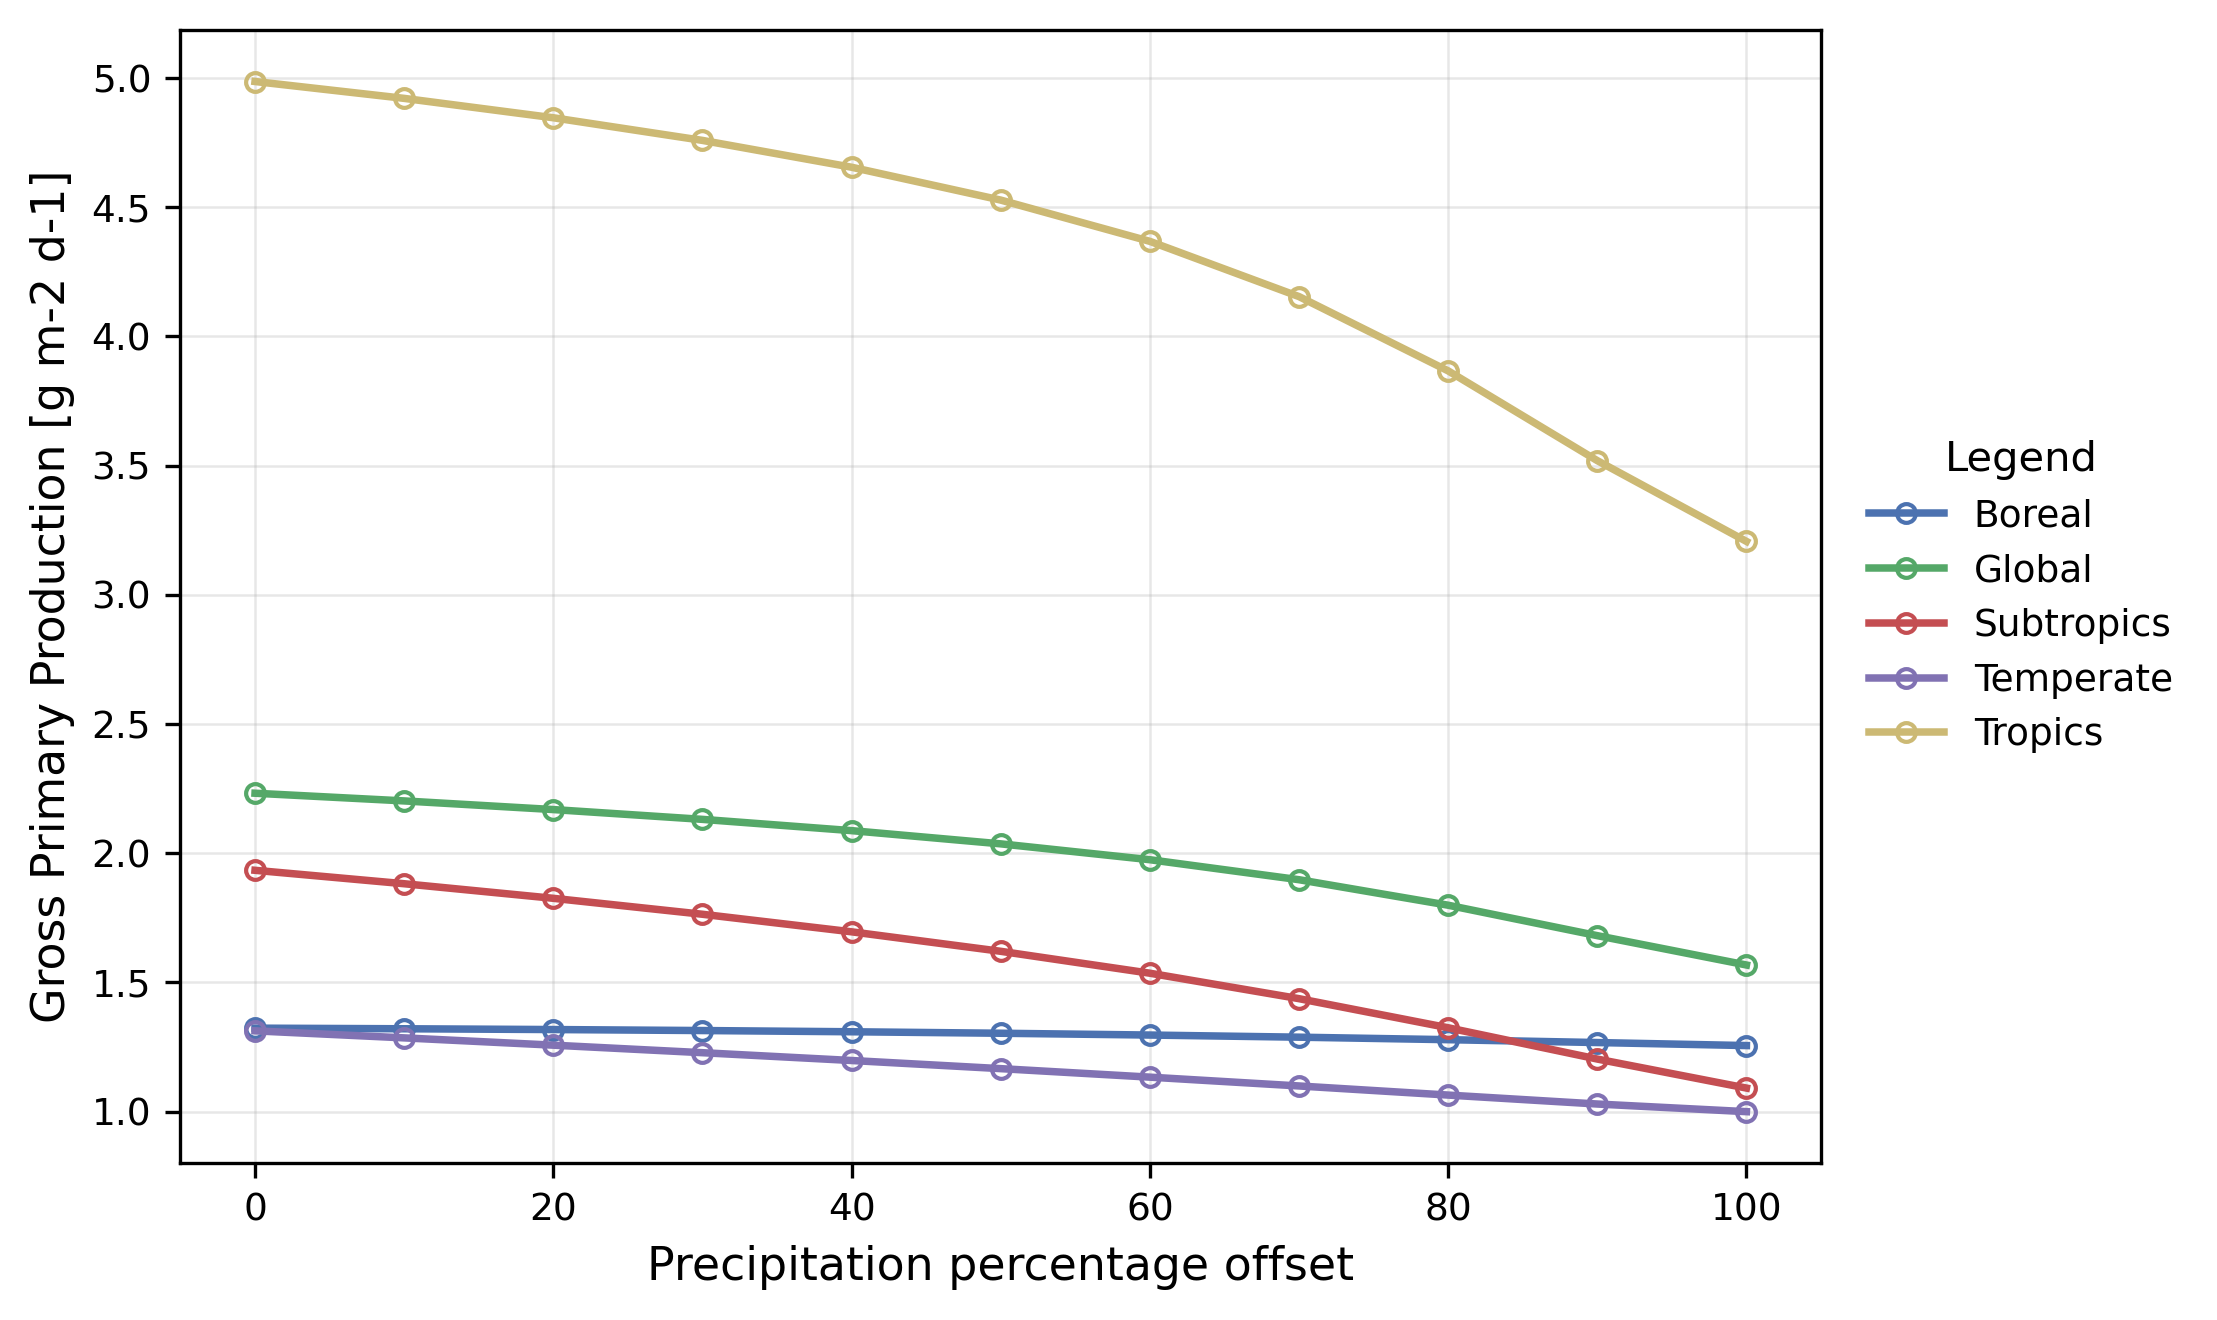

In [173]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response(df, variable="GrossPrimaryProduction",
                                 forcing_var="pre")

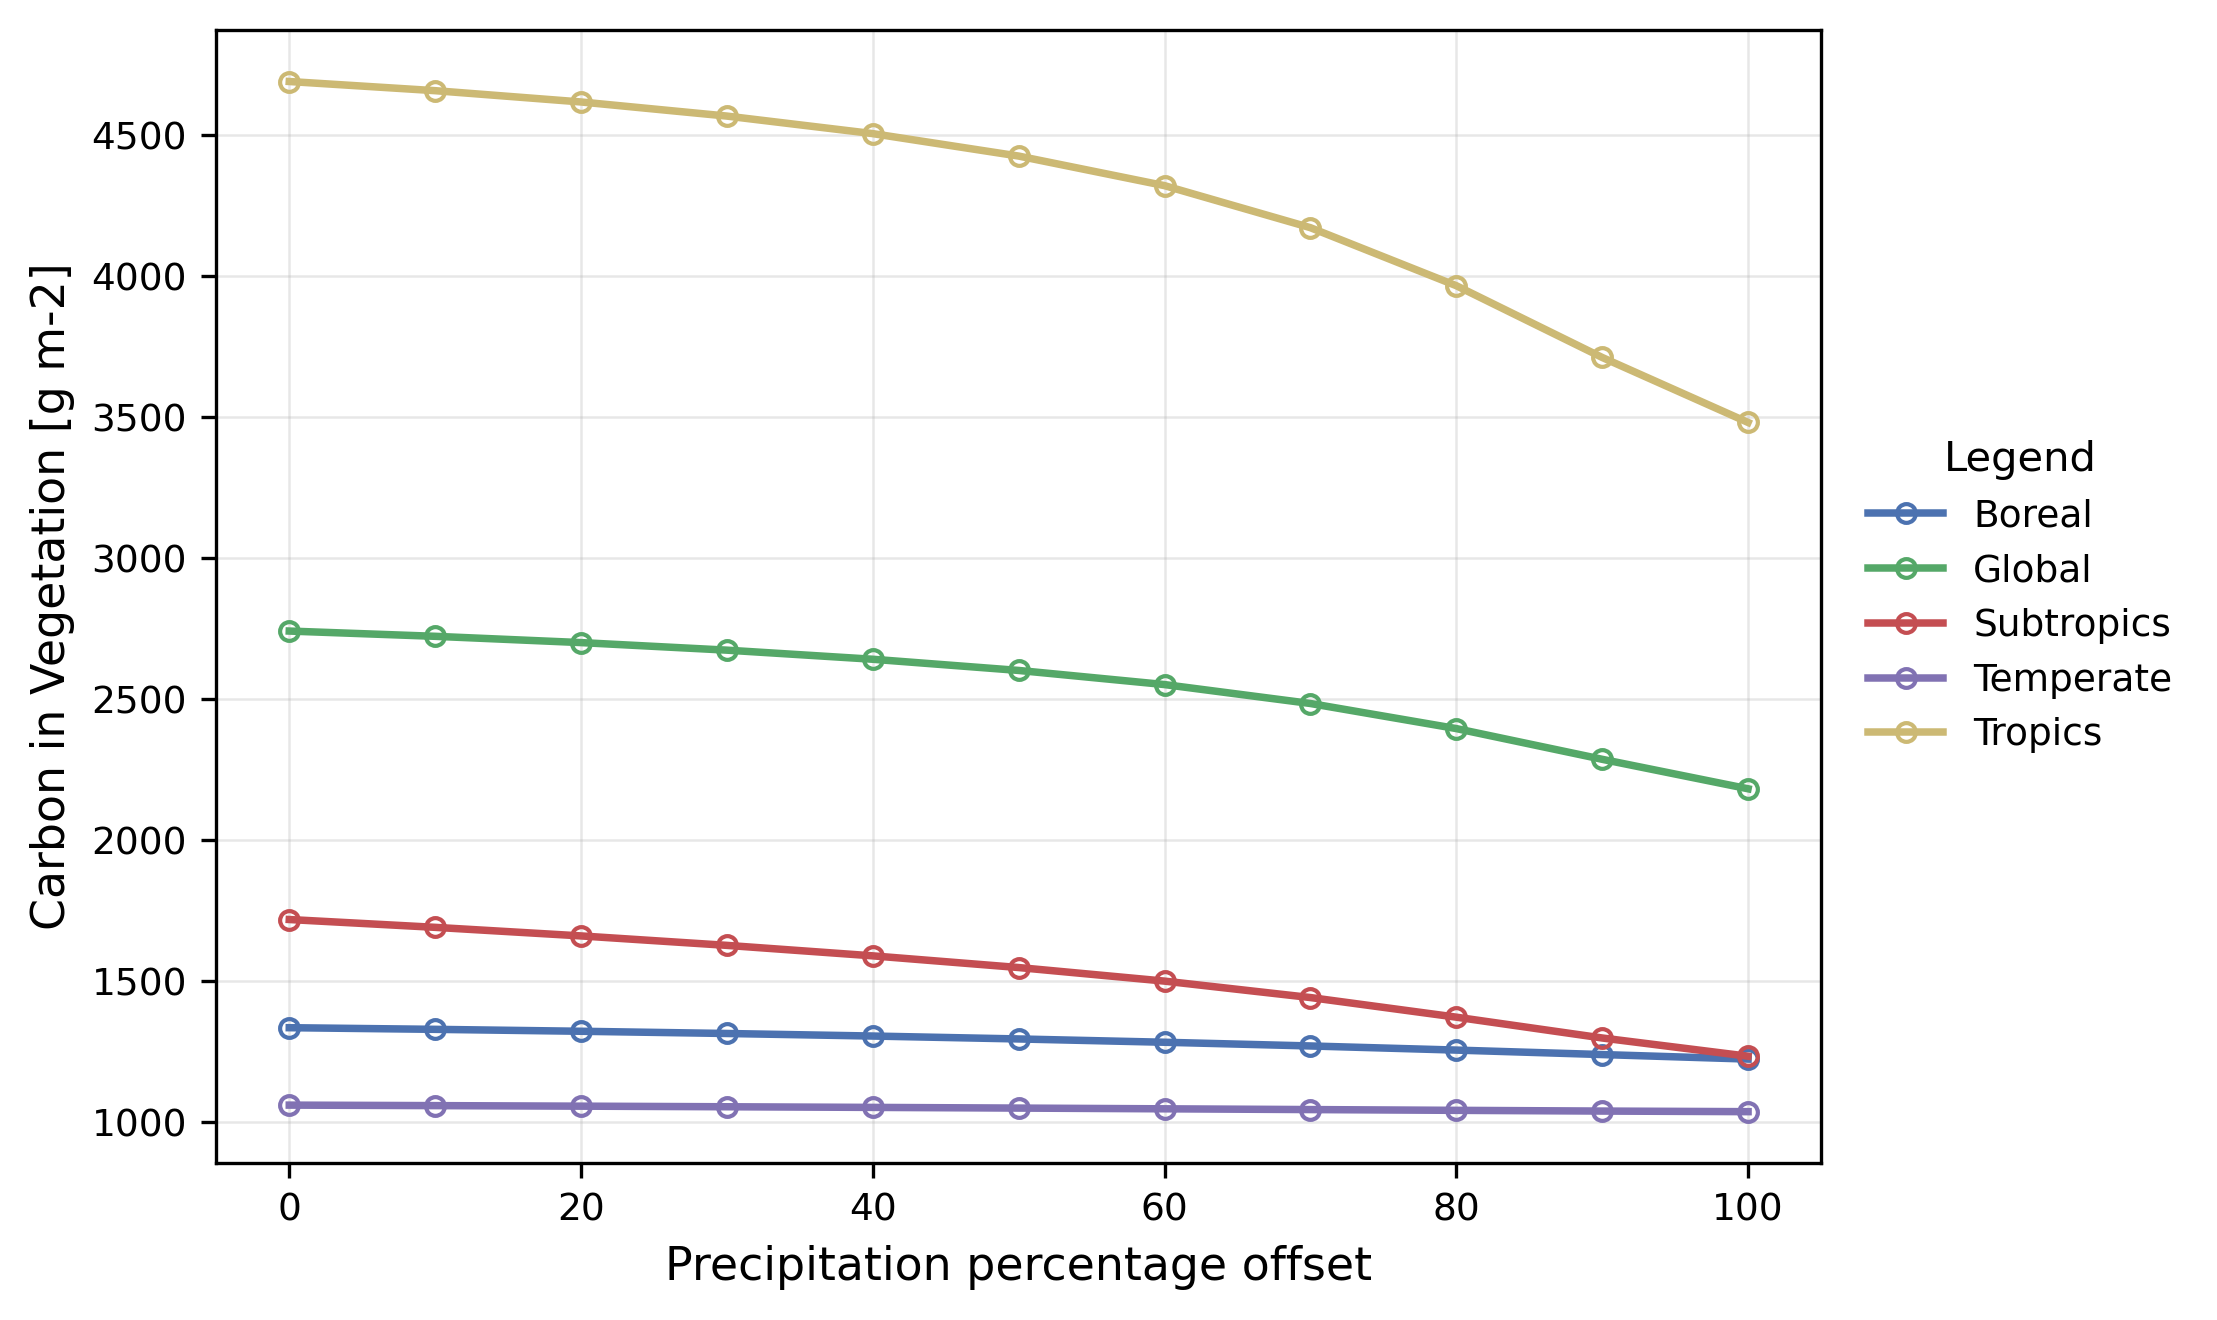

In [174]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response(df, variable="cVeg",
                                 forcing_var="pre")

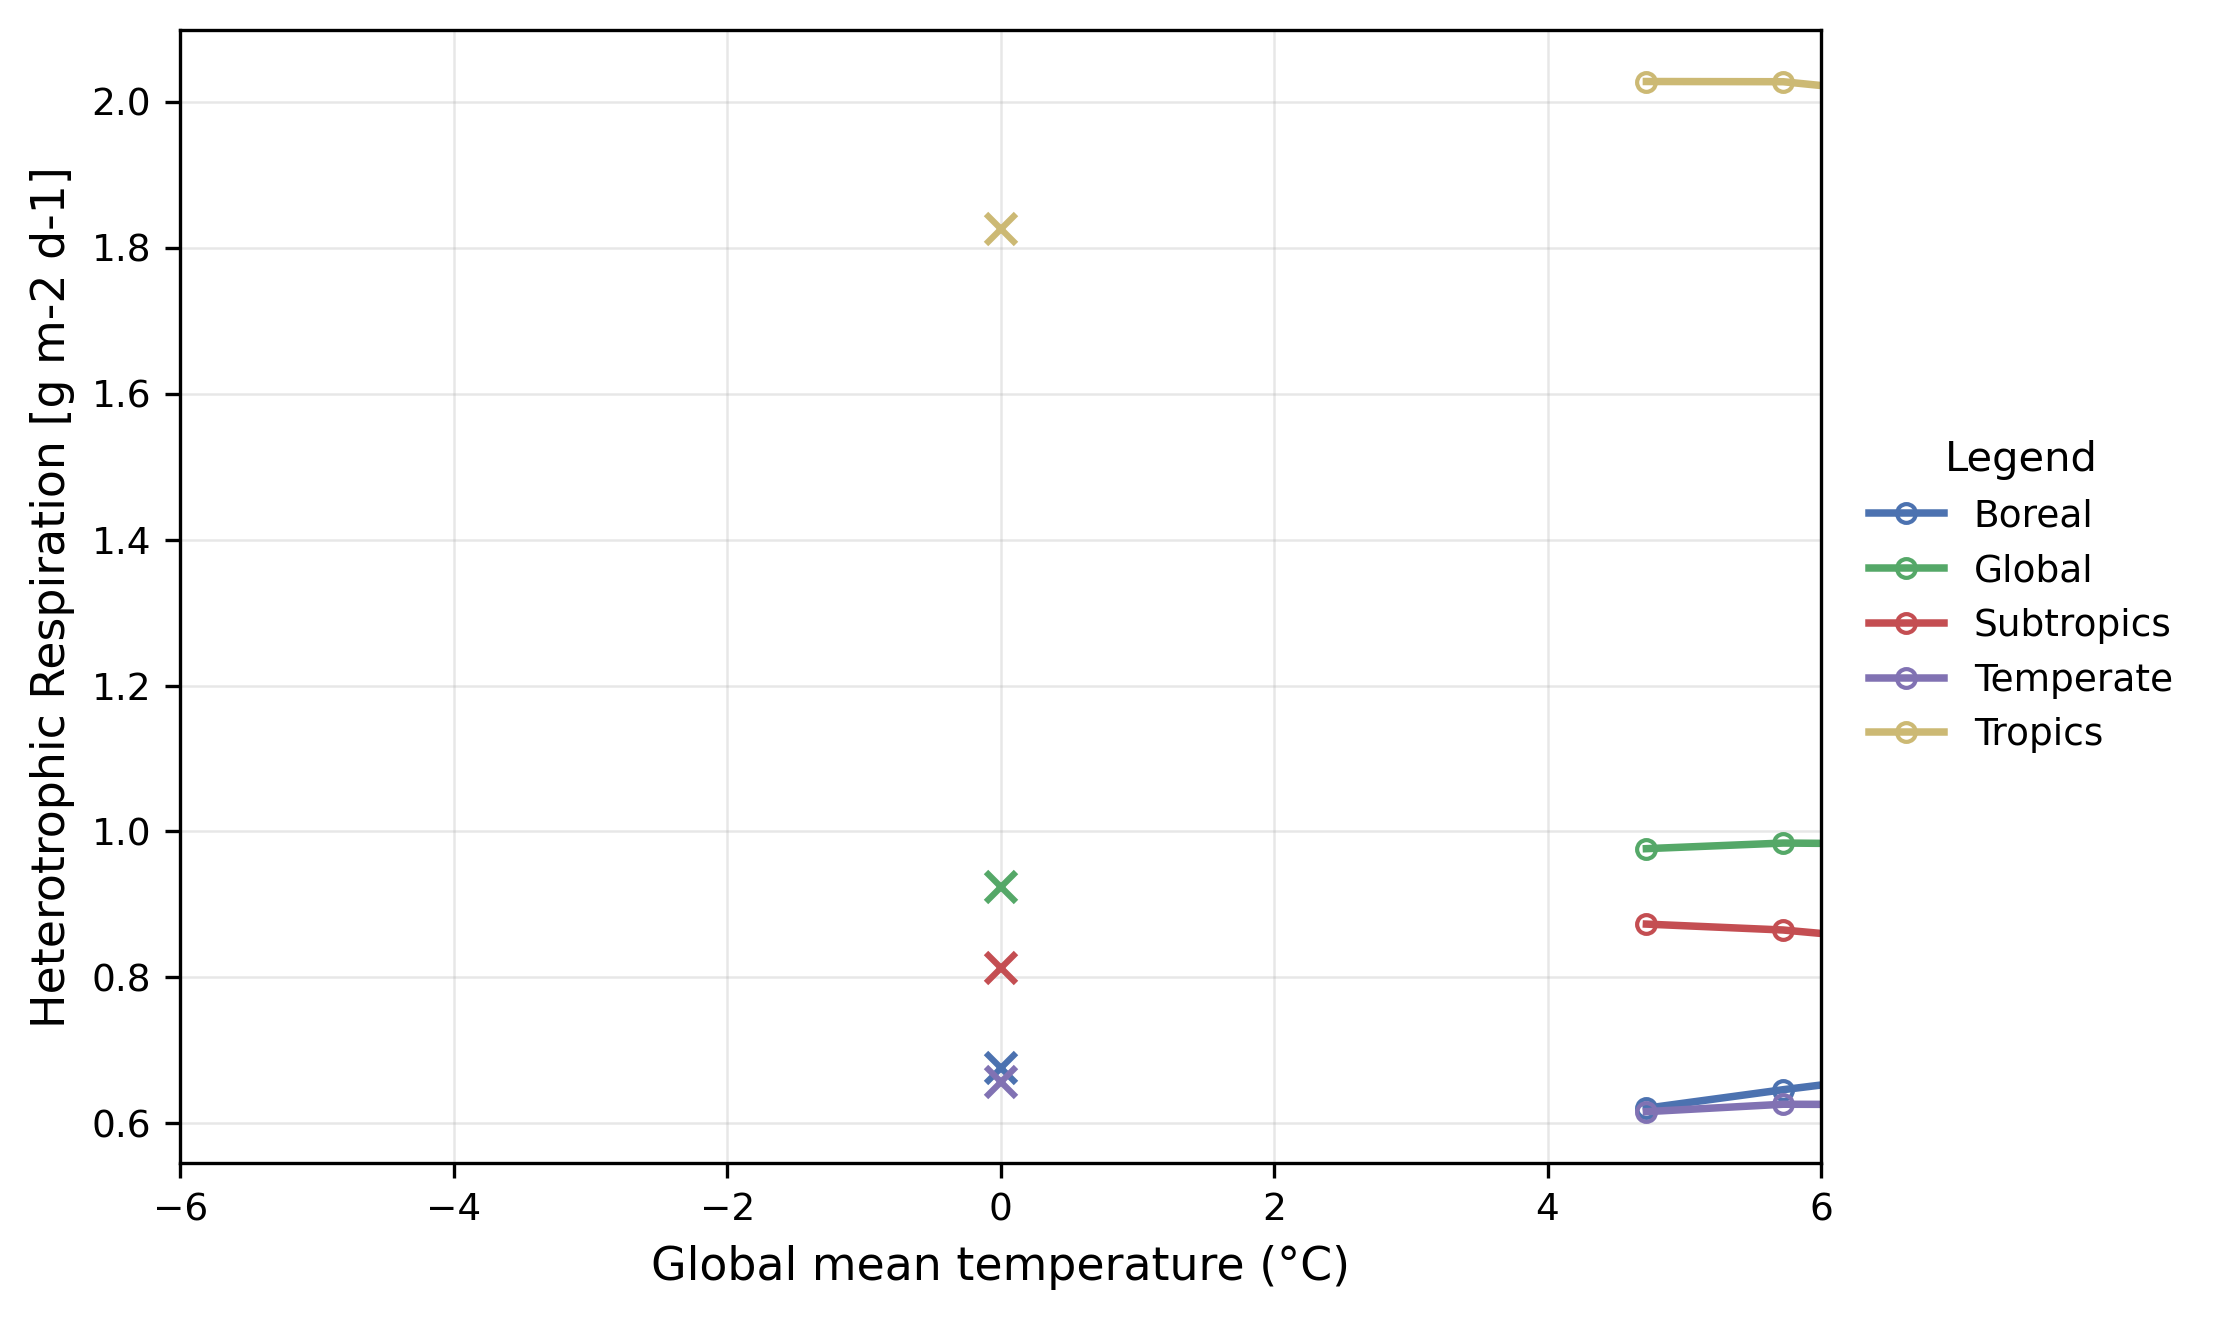

In [175]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response(df, variable="HeterotrophicRespiration",
                                 forcing_var="tmp", xlim=(-6,6))

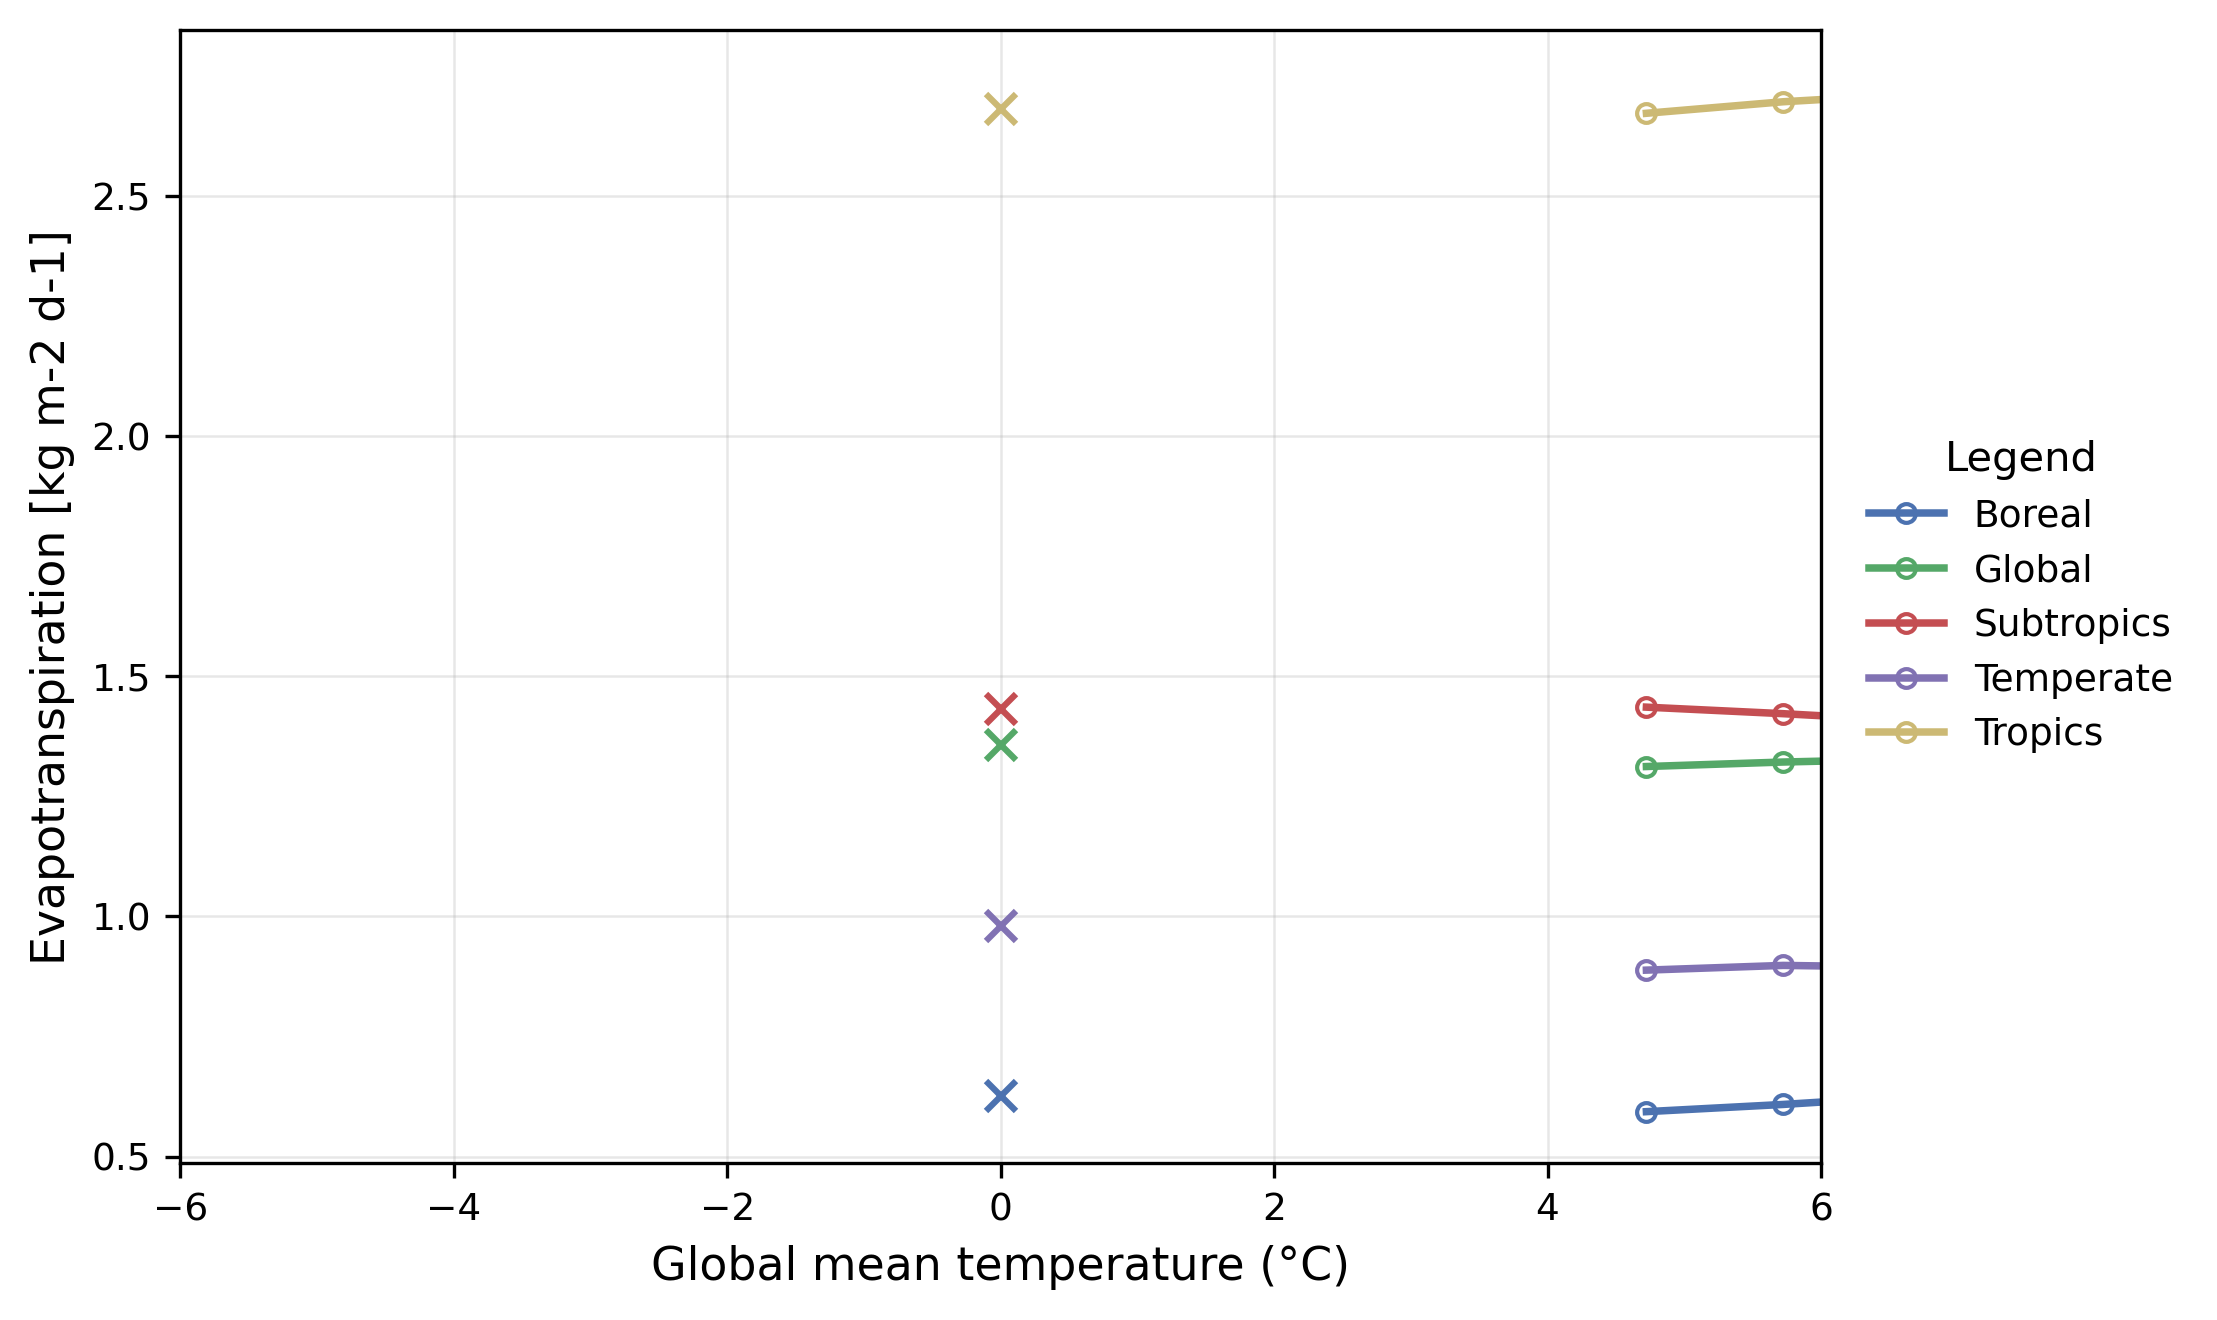

In [176]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response(df, variable="Evapotranspiration",
                                 forcing_var="tmp", xlim=(-6,6))